In [ ]:
# Email Spam Detection with CNN from Scratch
# ======================================
# This notebook builds a spam detection model using a Convolutional Neural Network (CNN)
# approach designed for text classification.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# For neural network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# For text processing
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

# 1. Download and extract the dataset
!wget -nc https://github.com/MWiechmann/enron_spam_data/raw/master/enron_spam_data.zip
!unzip -o enron_spam_data.zip

File ‘enron_spam_data.zip’ already there; not retrieving.

Archive:  enron_spam_data.zip
  inflating: enron_spam_data.csv     


In [ ]:
# 2. Load the CSV file
df = pd.read_csv('enron_spam_data.csv')

In [ ]:
# 3. Display dataset information
print(f"Total emails: {len(df)}")
print(f"Column names: {df.columns.tolist()}")

# Print the first few rows to understand the data structure
print("\nFirst few rows of the dataset:")
print(df.head(2))

Total emails: 33716
Column names: ['Message ID', 'Subject', 'Message', 'Spam/Ham', 'Date']

First few rows of the dataset:
   Message ID                       Subject  \
0           0  christmas tree farm pictures   
1           1      vastar resources , inc .   

                                             Message Spam/Ham        Date  
0                                                NaN      ham  1999-12-10  
1  gary , production from the high island larger ...      ham  1999-12-13  


In [ ]:
# 4. Check for label column and convert to binary
if 'Spam/Ham' in df.columns:
    # Convert Spam/Ham labels to binary (1 for spam, 0 for ham)
    df['label'] = df['Spam/Ham'].apply(lambda x: 1 if x.lower() == 'spam' else 0)
else:
    # Look for other potential label columns
    potential_label_cols = [col for col in df.columns if any(keyword in col.lower() for keyword in ['spam', 'ham', 'label', 'class'])]
    if potential_label_cols:
        print(f"Potential label columns found: {potential_label_cols}")
        # Use the first potential column
        df['label'] = df[potential_label_cols[0]].apply(lambda x: 1 if str(x).lower() == 'spam' else 0)
    else:
        raise ValueError("Couldn't identify label column in the dataset")

In [ ]:
# 5. Combine Subject and Message for better feature representation
df['text'] = "Subject: " + df['Subject'].fillna('') + " " + df['Message'].fillna('')

# Print dataset distribution
print(f"Spam emails: {sum(df['label'])}")
print(f"Ham emails: {len(df) - sum(df['label'])}")
print(f"Spam ratio: {sum(df['label'])/len(df):.2f}")

# Check if text column was correctly assigned
print("\nSample text column entries:")
print(df['text'].head(2).tolist())

# Display sample emails
print("\nSample SPAM email:")
spam_sample = df[df['label'] == 1]['text'].iloc[0]
print(spam_sample[:500] + "..." if len(str(spam_sample)) > 500 else spam_sample)

print("\nSample HAM email:")
ham_sample = df[df['label'] == 0]['text'].iloc[0]
print(ham_sample[:500] + "..." if len(str(ham_sample)) > 500 else ham_sample)


Spam emails: 17171
Ham emails: 16545
Spam ratio: 0.51

Sample text column entries:
['Subject: christmas tree farm pictures ', 'Subject: vastar resources , inc . gary , production from the high island larger block a - 1 # 2 commenced on\nsaturday at 2 : 00 p . m . at about 6 , 500 gross . carlos expects between 9 , 500 and\n10 , 000 gross for tomorrow . vastar owns 68 % of the gross production .\ngeorge x 3 - 6992\n- - - - - - - - - - - - - - - - - - - - - - forwarded by george weissman / hou / ect on 12 / 13 / 99 10 : 16\nam - - - - - - - - - - - - - - - - - - - - - - - - - - -\ndaren j farmer\n12 / 10 / 99 10 : 38 am\nto : carlos j rodriguez / hou / ect @ ect\ncc : george weissman / hou / ect @ ect , melissa graves / hou / ect @ ect\nsubject : vastar resources , inc .\ncarlos ,\nplease call linda and get everything set up .\ni \' m going to estimate 4 , 500 coming up tomorrow , with a 2 , 000 increase each\nfollowing day based on my conversations with bill fischer at bmar .\nd .\n- - 

In [ ]:
# 6. Text Preprocessing
def clean_text(text):
    """
    Clean the text by removing punctuation, numbers, extra spaces
    and converting to lowercase
    """
    if pd.isna(text):
        return ""

    # Convert to string
    text = str(text).lower()

    # Remove punctuation and numbers
    text = re.sub(f'[{string.punctuation}0-9]', ' ', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply cleaning
df['cleaned_text'] = df['text'].apply(clean_text)

# Check a cleaned example
print("\nExample of cleaned text:")
print(df['cleaned_text'].iloc[0][:500] + "..." if len(df['cleaned_text'].iloc[0]) > 500 else df['cleaned_text'].iloc[0])


Example of cleaned text:
subject christmas tree farm pictures


In [ ]:
# 7. Build vocabulary from most common words
def build_vocab(texts, max_words=10000):
    """Build a vocabulary of the most common words"""
    # Flatten all words
    all_words = ' '.join(texts).split()

    # Count and get most common
    word_counts = Counter(all_words)
    most_common = word_counts.most_common(max_words - 2)  # -2 for <PAD> and <UNK>

    # Create vocabulary with indices
    vocab = {'<PAD>': 0, '<UNK>': 1}
    for word, _ in most_common:
        vocab[word] = len(vocab)

    return vocab

# Create vocabulary from training data only
# First, split data to avoid data leakage
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df['label'])

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Build vocabulary from training data
VOCAB_SIZE = 10000
MAX_LENGTH = 200  # Maximum sequence length for CNN

vocab = build_vocab(train_df['cleaned_text'], max_words=VOCAB_SIZE)
print(f"Vocabulary size: {len(vocab)}")
print("Sample vocabulary items:", list(vocab.items())[:10])

Training set size: 24274
Validation set size: 2698
Test set size: 6744
Vocabulary size: 10000
Sample vocabulary items: [('<PAD>', 0), ('<UNK>', 1), ('the', 2), ('to', 3), ('and', 4), ('of', 5), ('a', 6), ('in', 7), ('for', 8), ('you', 9)]


In [ ]:
# 8. Convert text to numerical sequences
def text_to_sequence(text, vocab, max_length):
    """Convert text to a padded sequence of word indices"""
    words = text.split()
    # Truncate or pad as needed
    if len(words) > max_length:
        words = words[:max_length]
    else:
        words.extend(['<PAD>'] * (max_length - len(words)))

    # Convert to indices
    sequence = [vocab.get(word, vocab['<UNK>']) for word in words]
    return sequence

# Convert all texts to sequences
X_train = np.array([text_to_sequence(text, vocab, MAX_LENGTH)
                     for text in train_df['cleaned_text']])
X_val = np.array([text_to_sequence(text, vocab, MAX_LENGTH)
                   for text in val_df['cleaned_text']])
X_test = np.array([text_to_sequence(text, vocab, MAX_LENGTH)
                    for text in test_df['cleaned_text']])

y_train = train_df['label'].values
y_val = val_df['label'].values
y_test = test_df['label'].values

print(f"Input sequence shape: {X_train.shape}")

Input sequence shape: (24274, 200)


In [ ]:
# 9. Convert to PyTorch tensors
X_train_tensor = torch.LongTensor(X_train)
X_val_tensor = torch.LongTensor(X_val)
X_test_tensor = torch.LongTensor(X_test)

y_train_tensor = torch.LongTensor(y_train)
y_val_tensor = torch.LongTensor(y_val)
y_test_tensor = torch.LongTensor(y_test)

In [ ]:
# 10. Create data loaders
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [ ]:
# 11. Define the CNN model for text classification
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim,
                 dropout, pad_idx=0):
        super().__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        # Convolutional layers with different filter sizes
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1,
                      out_channels=n_filters,
                      kernel_size=(fs, embedding_dim))
            for fs in filter_sizes
        ])

        # Fully connected layer
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        # text shape: [batch size, sequence length]

        # Embedding layer
        embedded = self.embedding(text)
        # embedded shape: [batch size, sequence length, embedding dim]

        # Add channel dimension for Conv2d
        embedded = embedded.unsqueeze(1)
        # embedded shape: [batch size, 1, sequence length, embedding dim]

        # Apply convolutions
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        # conved_n shape: [batch size, n_filters, sequence length - filter_sizes[n] + 1]

        # Apply max pooling
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        # pooled_n shape: [batch size, n_filters]

        # Concatenate outputs from different filter sizes
        cat = self.dropout(torch.cat(pooled, dim=1))
        # cat shape: [batch size, n_filters * len(filter_sizes)]

        # Final linear layer
        return self.fc(cat)

In [ ]:
# 12. Initialize model and training parameters
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [3, 4, 5]
OUTPUT_DIM = 2  # Binary classification: spam/ham
DROPOUT = 0.5

model = TextCNN(vocab_size=len(vocab),
                embedding_dim=EMBEDDING_DIM,
                n_filters=N_FILTERS,
                filter_sizes=FILTER_SIZES,
                output_dim=OUTPUT_DIM,
                dropout=DROPOUT)

print(model)

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

TextCNN(
  (embedding): Embedding(10000, 100, padding_idx=0)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(4, 100), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(5, 100), stride=(1, 1))
  )
  (fc): Linear(in_features=300, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 1,120,902 trainable parameters


In [ ]:
# 13. Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# 14. Training function
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()

    epoch_loss = 0
    epoch_acc = 0

    for batch in dataloader:
        # Get batch data
        text, labels = batch
        text, labels = text.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        predictions = model(text)

        # Calculate loss
        loss = criterion(predictions, labels)

        # Backward pass and update
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        predictions = torch.argmax(predictions, dim=1)
        correct = (predictions == labels).float().sum()
        accuracy = correct / len(labels)

        # Update epoch metrics
        epoch_loss += loss.item()
        epoch_acc += accuracy.item()

    # Return average metrics
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [ ]:
# 15. Evaluation function
def evaluate(model, dataloader, criterion, device):
    model.eval()

    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for batch in dataloader:
            # Get batch data
            text, labels = batch
            text, labels = text.to(device), labels.to(device)

            # Forward pass
            predictions = model(text)

            # Calculate loss
            loss = criterion(predictions, labels)

            # Calculate accuracy
            predictions = torch.argmax(predictions, dim=1)
            correct = (predictions == labels).float().sum()
            accuracy = correct / len(labels)

            # Update epoch metrics
            epoch_loss += loss.item()
            epoch_acc += accuracy.item()

    # Return average metrics
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [ ]:
# 16. Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Using device: {device}")

N_EPOCHS = 10
best_valid_acc = 0

# For plotting results
train_losses = []
val_losses = []
train_accs = []
val_accs = []

# Create a nice-looking progress bar
from tqdm.notebook import tqdm

print("Starting training...")
for epoch in tqdm(range(N_EPOCHS)):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluate
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Save best model
    if val_acc > best_valid_acc:
        best_valid_acc = val_acc
        torch.save(model.state_dict(), 'best-cnn-model.pt')

    print(f'Epoch: {epoch+1}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal. Loss: {val_loss:.3f} | Val. Acc: {val_acc*100:.2f}%')

Using device: cpu
Starting training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
	Train Loss: 0.244 | Train Acc: 89.24%
	Val. Loss: 0.088 | Val. Acc: 97.09%
Epoch: 2
	Train Loss: 0.093 | Train Acc: 96.59%
	Val. Loss: 0.052 | Val. Acc: 97.97%
Epoch: 3
	Train Loss: 0.054 | Train Acc: 98.10%
	Val. Loss: 0.039 | Val. Acc: 98.58%
Epoch: 4
	Train Loss: 0.037 | Train Acc: 98.64%
	Val. Loss: 0.037 | Val. Acc: 98.66%
Epoch: 5
	Train Loss: 0.021 | Train Acc: 99.23%
	Val. Loss: 0.036 | Val. Acc: 98.84%
Epoch: 6
	Train Loss: 0.019 | Train Acc: 99.34%
	Val. Loss: 0.033 | Val. Acc: 98.84%
Epoch: 7
	Train Loss: 0.014 | Train Acc: 99.51%
	Val. Loss: 0.032 | Val. Acc: 99.09%
Epoch: 8
	Train Loss: 0.010 | Train Acc: 99.63%
	Val. Loss: 0.034 | Val. Acc: 99.06%
Epoch: 9
	Train Loss: 0.009 | Train Acc: 99.70%
	Val. Loss: 0.038 | Val. Acc: 98.91%
Epoch: 10
	Train Loss: 0.008 | Train Acc: 99.72%
	Val. Loss: 0.039 | Val. Acc: 98.87%


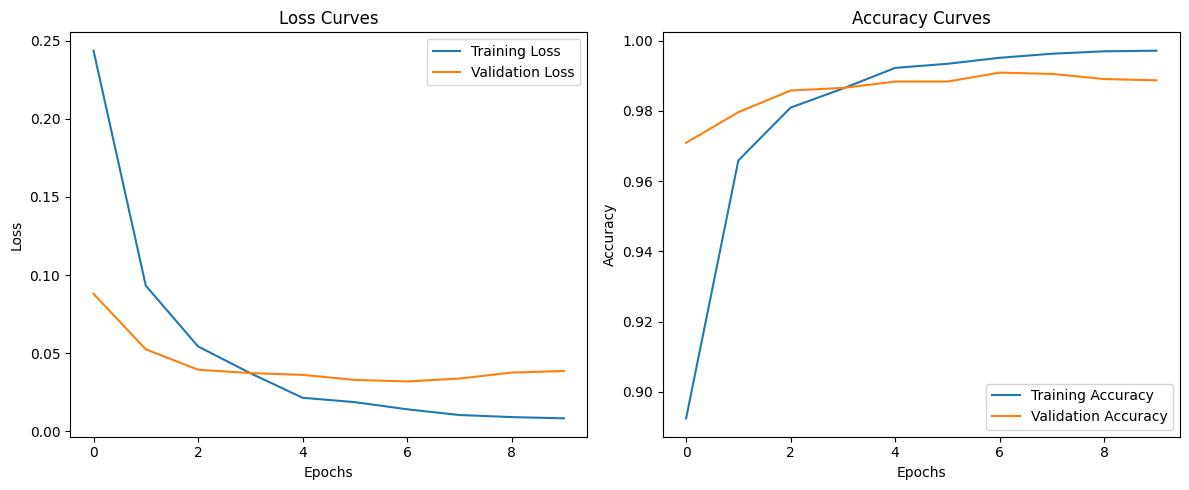

In [ ]:
# 17. Plot training and validation metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.tight_layout()
plt.show()

In [ ]:
# 18. Load the best model for testing
model.load_state_dict(torch.load('best-cnn-model.pt'))

<ipython-input-35-bc0f22cbeee8>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best-cnn-model.pt'))


<All keys matched successfully>

In [ ]:
# 19. Evaluate on test set
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.032 | Test Acc: 99.01%



Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3309
           1       0.99      0.99      0.99      3435

    accuracy                           0.99      6744
   macro avg       0.99      0.99      0.99      6744
weighted avg       0.99      0.99      0.99      6744



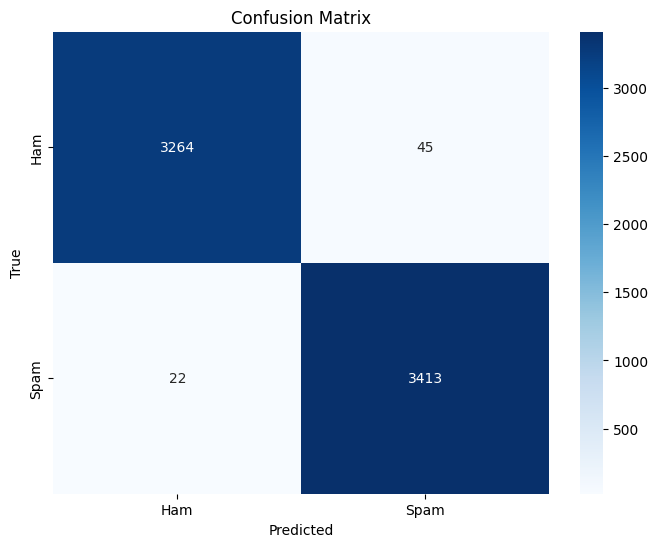

In [ ]:
# 20. Generate detailed metrics
y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        text, labels = batch
        text, labels = text.to(device), labels.to(device)

        predictions = model(text)
        predictions = torch.argmax(predictions, dim=1)

        y_pred.extend(predictions.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# 21. Save the complete model including vocabulary
model_data = {
    'vocab': vocab,
    'model_state_dict': model.state_dict(),
    'model_config': {
        'vocab_size': len(vocab),
        'embedding_dim': EMBEDDING_DIM,
        'n_filters': N_FILTERS,
        'filter_sizes': FILTER_SIZES,
        'output_dim': OUTPUT_DIM,
        'dropout': DROPOUT
    },
    'max_length': MAX_LENGTH
}

torch.save(model_data, 'spam_detection_cnn.pt')
print("Complete model saved to 'spam_detection_cnn.pt'")

Complete model saved to 'spam_detection_cnn.pt'


In [ ]:
# 22. Function to predict on new emails
def predict_spam_cnn(emails, model_path='spam_detection_cnn.pt'):
    # Load the model data
    model_data = torch.load(model_path)

    # Extract components
    vocab = model_data['vocab']
    model_config = model_data['model_config']
    max_length = model_data['max_length']

    # Recreate the model
    model = TextCNN(
        vocab_size=model_config['vocab_size'],
        embedding_dim=model_config['embedding_dim'],
        n_filters=model_config['n_filters'],
        filter_sizes=model_config['filter_sizes'],
        output_dim=model_config['output_dim'],
        dropout=model_config['dropout']
    )

    # Load saved parameters
    model.load_state_dict(model_data['model_state_dict'])
    model.eval()

    # Process the emails
    processed_emails = [clean_text(email) for email in emails]
    sequences = [text_to_sequence(text, vocab, max_length) for text in processed_emails]

    # Convert to tensor
    input_tensor = torch.LongTensor(sequences)

    # Make predictions
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = F.softmax(outputs, dim=1)
        predictions = torch.argmax(probabilities, dim=1)

    # Prepare results
    results = []
    for i, email in enumerate(emails):
        label = "SPAM" if predictions[i].item() == 1 else "HAM"
        confidence = probabilities[i][predictions[i]].item()
        results.append({
            "email": email[:100] + "..." if len(email) > 100 else email,
            "prediction": label,
            "confidence": f"{confidence:.4f}"
        })

    return pd.DataFrame(results)

In [ ]:
# 23. Test with example emails
example_emails = [
    "Hello, just checking in about the meeting tomorrow. Let me know if you need anything from me before then.",
    "CONGRATULATIONS! You've WON $10,000,000.00 in our lottery! Send your bank details now to claim your prize!",
    "Please find attached the quarterly report for your review. Let me know if you have any questions.",
    "URGENT: Your account has been compromised. Click here immediately to verify your details and secure your account."
]

prediction_df = predict_spam_cnn(example_emails)
print("\nPredictions on new emails:")
print(prediction_df)



Predictions on new emails:
                                               email prediction confidence
0  Hello, just checking in about the meeting tomo...        HAM     1.0000
1  CONGRATULATIONS! You've WON $10,000,000.00 in ...       SPAM     1.0000
2  Please find attached the quarterly report for ...        HAM     1.0000
3  URGENT: Your account has been compromised. Cli...       SPAM     1.0000


<ipython-input-39-79d4c3939eff>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_data = torch.load(model_path)


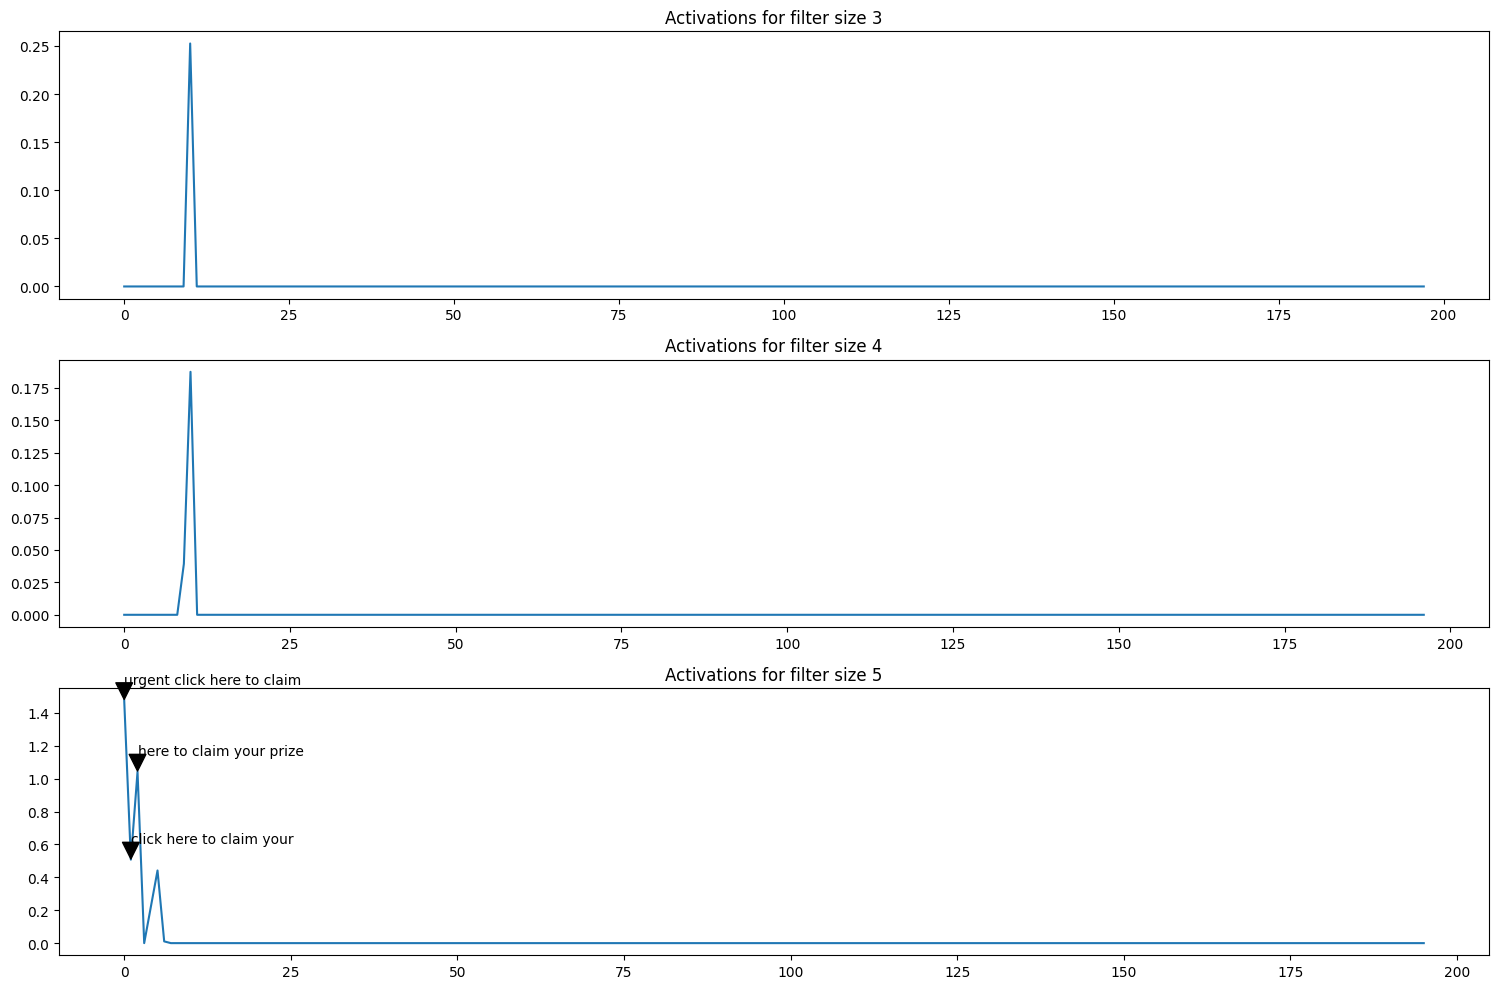

In [ ]:

# 24. Visualize CNN filters (optional)
def visualize_filter_activations(model, text, vocab, max_length, device='cpu'):
    """Visualize which n-grams activate CNN filters the most"""
    # Process text
    processed_text = clean_text(text)
    sequence = text_to_sequence(processed_text, vocab, max_length)

    # Convert to tensor and get embeddings
    input_tensor = torch.LongTensor([sequence]).to(device)
    model.eval()

    with torch.no_grad():
        # Get embedding activations
        embedded = model.embedding(input_tensor).unsqueeze(1)

        # Get convolution activations before pooling
        activations = [F.relu(conv(embedded)).squeeze(3) for conv in model.convs]

    # Display results
    words = processed_text.split()[:max_length]

    # For each filter size
    plt.figure(figsize=(15, 10))
    for i, (activation, filter_size) in enumerate(zip(activations, FILTER_SIZES)):
        # Get activations for first filter of this size
        activation = activation[0, 0].cpu().numpy()

        # Plot top activating n-grams
        plt.subplot(len(FILTER_SIZES), 1, i+1)
        plt.plot(activation)
        plt.title(f'Activations for filter size {filter_size}')

        # Mark top 3 activations
        top_indices = activation.argsort()[-3:]
        for idx in top_indices:
            if idx < len(words) - filter_size + 1:
                ngram = ' '.join(words[idx:idx+filter_size])
                plt.annotate(ngram, xy=(idx, activation[idx]),
                            xytext=(idx, activation[idx]+0.1),
                            arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()

# Visualize filter activations for a spam example
spam_example = "URGENT: Click here to claim your prize of $1,000,000! Limited time offer!"
visualize_filter_activations(model, spam_example, vocab, MAX_LENGTH, device)